# Rocket Bunny Dashboard Prototype

FILENAME: rb_visuals.ipynb

DATE CREATED: 10-APR-21

## PHASE 1: Environment Setup

In [9]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import numpy as np
import getpass as gp

import pandas_ta as ta
import requests

from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

Function declaration

In [2]:
def is_ma_pos(val):
    
    if val > 0:
        return True
    else:
        return False

In [3]:
def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [4]:
def rma(x, n, y0):
        a = (n-1) / n
        ak = a**np.arange(len(x)-1, -1, -1)
        return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

Class definition

## PHASE 2: Data ETL

Read in the raw data

In [5]:


raw_data = pd.read_csv("data/bunny-usd-max-apr21.csv")
#data = data.query("type == 'conventional' and region == 'Albany'")
#raw_data["date"] = pd.to_datetime(raw_data["date"], format="%Y-%m-%d")

#data.sort_values("Date", inplace=True)

raw_data.head(5)

snapped_at         price  market_cap  total_volume
0  2021-03-12 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07
1  2021-03-13 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07
2  2021-03-14 00:00:00 UTC  2.723985e-11         0.0  4.711907e+06
3  2021-03-15 00:00:00 UTC  2.276712e-11         0.0  1.814948e+06
4  2021-03-16 00:00:00 UTC  3.197680e-11         0.0  1.701247e+06

In [6]:
app = dash.Dash(__name__)

In [7]:

data = raw_data.rename({'snapped_at': 'dtg'}, axis=1)
data.dtypes

dtg              object
price           float64
market_cap      float64
total_volume    float64
dtype: object

In [8]:
col_list = list(data.columns)
col_list

['dtg', 'price', 'market_cap', 'total_volume']

In [9]:
close_np = data['price'].to_list()
close_np

[3.544890372449417e-11,
 3.544890372449417e-11,
 2.7239851621885825e-11,
 2.276711980520152e-11,
 3.1976800418536546e-11,
 2.8077474254547858e-11,
 2.1126616432418585e-11,
 2.0963108885770787e-11,
 1.7818568348394942e-11,
 1.714732901367917e-11,
 1.2481281902033133e-11,
 1.2533681483670114e-11,
 1.1875716146667161e-11,
 9.457534146178276e-12,
 7.305428315404949e-12,
 8.744554690166982e-12,
 7.207941603822242e-12,
 7.650775307094981e-12,
 9.388180178763074e-12,
 7.174640793551023e-12,
 8.115413911027787e-12,
 7.999102012443927e-12,
 8.651487749048858e-12,
 9.409349711694989e-12,
 1.0896905187671577e-11,
 1.5142164424853266e-11,
 1.6785648600218088e-11,
 1.0765405784247136e-11,
 1.4312424017942007e-11,
 1.4048118388124779e-11,
 1.1963189826467365e-11,
 1.2699972771176136e-11,
 1.1419131925727329e-11,
 1.018680681125154e-11,
 1.1735694210638596e-11,
 1.087416484991724e-11,
 1.6041310947745593e-11,
 1.6507045452453323e-11,
 1.7379380747873198e-11,
 2.5355351928978517e-11,
 2.29100168912033

In [10]:
data['date'] = pd.to_datetime(data['dtg']).dt.date
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['hour'] = pd.DatetimeIndex(data['date']).hour.astype(str)

In [11]:
data

dtg         price  market_cap  total_volume  \
0   2021-03-12 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
1   2021-03-13 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
2   2021-03-14 00:00:00 UTC  2.723985e-11         0.0  4.711907e+06   
3   2021-03-15 00:00:00 UTC  2.276712e-11         0.0  1.814948e+06   
4   2021-03-16 00:00:00 UTC  3.197680e-11         0.0  1.701247e+06   
5   2021-03-17 00:00:00 UTC  2.807747e-11         0.0  1.015236e+06   
6   2021-03-18 00:00:00 UTC  2.112662e-11         0.0  7.644860e+05   
7   2021-03-19 00:00:00 UTC  2.096311e-11         0.0  5.282036e+05   
8   2021-03-20 00:00:00 UTC  1.781857e-11         0.0  3.706957e+05   
9   2021-03-21 00:00:00 UTC  1.714733e-11         0.0  3.667799e+05   
10  2021-03-22 00:00:00 UTC  1.248128e-11         0.0  2.645174e+05   
11  2021-03-23 00:00:00 UTC  1.253368e-11         0.0  2.989491e+05   
12  2021-03-24 00:00:00 UTC  1.187572e-11         0.0  2.446592e+05   
13  2021-03-25 00:00:00 UTC  9.457534e-12         0.0  9.767863e+04   
14  2021-03-26 00:00:00 UTC  7.305428e-12         0.0  1.588256e+05   
15  2021-03-27 00:00:00 UTC  8.744555e-12         0.0  7.500085e+04   
16  2021-03-28 00:00:00 UTC  7.207942e-12         0.0  8.720499e+04   
17  2021-03-29 00:00:00 UTC  7.650775e-12         0.0  1.179895e+05   
18  2021-03-30 00:00:00 UTC  9.388180e-12         0.0  1.756815e+05   
19  2021-03-31 00:00:00 UTC  7.174641e-12         0.0  1.475005e+05   
20  2021-04-01 00:00:00 UTC  8.115414e-12         0.0  4.018831e+04   
21  2021-04-02 00:00:00 UTC  7.999102e-12         0.0  3.436873e+04   
22  2021-04-03 00:00:00 UTC  8.651488e-12         0.0  6.746490e+04   
23  2021-04-04 00:00:00 UTC  9.409350e-12         0.0  1.252161e+05   
24  2021-04-05 00:00:00 UTC  1.089691e-11         0.0  9.844083e+04   
25  2021-04-06 00:00:00 UTC  1.514216e-11         0.0  3.364923e+05   
26  2021-04-07 00:00:00 UTC  1.678565e-11         0.0  1.289085e+05   
27  2021-04-08 00:00:00 UTC  1.076541e-11         0.0  1.224956e+05   
28  2021-04-09 00:00:00 UTC  1.431242e-11         0.0  1.675105e+05   
29  2021-04-10 00:00:00 UTC  1.404812e-11         0.0  7.070397e+04   
30  2021-04-11 00:00:00 UTC  1.196319e-11         0.0  4.130647e+04   
31  2021-04-12 00:00:00 UTC  1.269997e-11         0.0  6.590754e+04   
32  2021-04-13 00:00:00 UTC  1.141913e-11         0.0  3.696984e+04   
33  2021-04-14 00:00:00 UTC  1.018681e-11         0.0  1.715708e+05   
34  2021-04-15 00:00:00 UTC  1.173569e-11         0.0  8.805396e+04   
35  2021-04-16 00:00:00 UTC  1.087416e-11         0.0  4.975255e+04   
36  2021-04-17 00:00:00 UTC  1.604131e-11         0.0  3.329665e+05   
37  2021-04-18 00:00:00 UTC  1.650705e-11         0.0  2.723470e+05   
38  2021-04-19 00:00:00 UTC  1.737938e-11         0.0  1.467940e+05   
39  2021-04-20 00:00:00 UTC  2.535535e-11         0.0  5.664851e+05   
40  2021-04-21 00:00:00 UTC  2.291002e-11         0.0  3.947602e+05   
41  2021-04-22 00:00:00 UTC  3.690263e-11         0.0  7.068618e+05   
42  2021-04-23 00:00:00 UTC  3.763102e-11         0.0  5.253981e+05   
43  2021-04-24 00:00:00 UTC  3.467351e-11         0.0  1.921884e+05   
44  2021-04-25 00:00:00 UTC  3.043825e-11         0.0  1.519698e+05   
45  2021-04-26 00:00:00 UTC  3.123134e-11         0.0  1.880725e+05   
46  2021-04-27 00:00:00 UTC  3.786112e-11         0.0  2.767010e+05   
47  2021-04-28 00:00:00 UTC  4.012479e-11         0.0  1.649422e+05   
48  2021-04-29 00:00:00 UTC  3.072171e-11         0.0  2.037915e+05   
49  2021-04-30 00:00:00 UTC  2.729628e-11         0.0  1.770153e+05   
50  2021-05-01 00:00:00 UTC  2.754812e-11         0.0  1.528080e+05   

          date  year  month  day hour  
0   2021-03-12  2021      3   12    0  
1   2021-03-13  2021      3   13    0  
2   2021-03-14  2021      3   14    0  
3   2021-03-15  2021      3   15    0  
4   2021-03-16  2021      3   16    0  
5   2021-03-17  2021      3   17    0  
6   2021-03-18  2021      3   18    0  
7   2021-03

Calculate 'gain' and 'loss' columns

In [12]:
data['close_diff'] = data['price'].diff()
data['bool_close_diff'] = data['close_diff'].apply(is_ma_pos)

In [13]:
data['gain'] = data.close_diff.mask(data.close_diff < 0, 0.0)
data['loss'] = -data.close_diff.mask(data.close_diff > 0, -0.0)

n=14 # rsi window number
data['avg_gain'] = rma(data.gain[n+1:].to_numpy(), n, np.nansum(data.gain.to_numpy()[:n+1])/n)
data['avg_loss'] = rma(data.loss[n+1:].to_numpy(), n, np.nansum(data.loss.to_numpy()[:n+1])/n)


Calculate rolling mean

In [14]:
data['SMA7'] = data['price'].rolling(window=7).mean()
data['SMA30'] = data['price'].rolling(window=30).mean()

Calculate rolling standard deviation

In [15]:
data['STD7'] = data['price'].rolling(window=7).std()
data['STD30'] = data['price'].rolling(window=30).std()

#data['STD99'] = self.aggregate_df['Close'].rolling(window=99).std()

Calculate rolling variance

In [16]:
data['VAR7'] = data['price'].rolling(window=7).var()
data['VAR30'] = data['price'].rolling(window=30).var()

#data['VAR99'] = self.aggregate_df['Close'].rolling(window=99).var()

Calculate MACD

In [17]:
data['SMA-MACD'] = data['SMA7'] - data['SMA30']
data['SMA-MACD-ratio'] = data['SMA7'] / data['SMA30']
data['bool_diff_SMA7_SMA30'] = data['SMA-MACD'].apply(is_ma_pos)

Calculate EMA

In [18]:
window = 12

In [19]:
data["EMA12"] = ta.ema(data["price"], length=12)
data["EMA20"] = ta.ema(data["price"], length=20)
data

dtg         price  market_cap  total_volume  \
0   2021-03-12 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
1   2021-03-13 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
2   2021-03-14 00:00:00 UTC  2.723985e-11         0.0  4.711907e+06   
3   2021-03-15 00:00:00 UTC  2.276712e-11         0.0  1.814948e+06   
4   2021-03-16 00:00:00 UTC  3.197680e-11         0.0  1.701247e+06   
5   2021-03-17 00:00:00 UTC  2.807747e-11         0.0  1.015236e+06   
6   2021-03-18 00:00:00 UTC  2.112662e-11         0.0  7.644860e+05   
7   2021-03-19 00:00:00 UTC  2.096311e-11         0.0  5.282036e+05   
8   2021-03-20 00:00:00 UTC  1.781857e-11         0.0  3.706957e+05   
9   2021-03-21 00:00:00 UTC  1.714733e-11         0.0  3.667799e+05   
10  2021-03-22 00:00:00 UTC  1.248128e-11         0.0  2.645174e+05   
11  2021-03-23 00:00:00 UTC  1.253368e-11         0.0  2.989491e+05   
12  2021-03-24 00:00:00 UTC  1.187572e-11         0.0  2.446592e+05   
13  2021-03-25 00:00:00 UTC  9.457534e-12         0.0  9.767863e+04   
14  2021-03-26 00:00:00 UTC  7.305428e-12         0.0  1.588256e+05   
15  2021-03-27 00:00:00 UTC  8.744555e-12         0.0  7.500085e+04   
16  2021-03-28 00:00:00 UTC  7.207942e-12         0.0  8.720499e+04   
17  2021-03-29 00:00:00 UTC  7.650775e-12         0.0  1.179895e+05   
18  2021-03-30 00:00:00 UTC  9.388180e-12         0.0  1.756815e+05   
19  2021-03-31 00:00:00 UTC  7.174641e-12         0.0  1.475005e+05   
20  2021-04-01 00:00:00 UTC  8.115414e-12         0.0  4.018831e+04   
21  2021-04-02 00:00:00 UTC  7.999102e-12         0.0  3.436873e+04   
22  2021-04-03 00:00:00 UTC  8.651488e-12         0.0  6.746490e+04   
23  2021-04-04 00:00:00 UTC  9.409350e-12         0.0  1.252161e+05   
24  2021-04-05 00:00:00 UTC  1.089691e-11         0.0  9.844083e+04   
25  2021-04-06 00:00:00 UTC  1.514216e-11         0.0  3.364923e+05   
26  2021-04-07 00:00:00 UTC  1.678565e-11         0.0  1.289085e+05   
27  2021-04-08 00:00:00 UTC  1.076541e-11         0.0  1.224956e+05   
28  2021-04-09 00:00:00 UTC  1.431242e-11         0.0  1.675105e+05   
29  2021-04-10 00:00:00 UTC  1.404812e-11         0.0  7.070397e+04   
30  2021-04-11 00:00:00 UTC  1.196319e-11         0.0  4.130647e+04   
31  2021-04-12 00:00:00 UTC  1.269997e-11         0.0  6.590754e+04   
32  2021-04-13 00:00:00 UTC  1.141913e-11         0.0  3.696984e+04   
33  2021-04-14 00:00:00 UTC  1.018681e-11         0.0  1.715708e+05   
34  2021-04-15 00:00:00 UTC  1.173569e-11         0.0  8.805396e+04   
35  2021-04-16 00:00:00 UTC  1.087416e-11         0.0  4.975255e+04   
36  2021-04-17 00:00:00 UTC  1.604131e-11         0.0  3.329665e+05   
37  2021-04-18 00:00:00 UTC  1.650705e-11         0.0  2.723470e+05   
38  2021-04-19 00:00:00 UTC  1.737938e-11         0.0  1.467940e+05   
39  2021-04-20 00:00:00 UTC  2.535535e-11         0.0  5.664851e+05   
40  2021-04-21 00:00:00 UTC  2.291002e-11         0.0  3.947602e+05   
41  2021-04-22 00:00:00 UTC  3.690263e-11         0.0  7.068618e+05   
42  2021-04-23 00:00:00 UTC  3.763102e-11         0.0  5.253981e+05   
43  2021-04-24 00:00:00 UTC  3.467351e-11         0.0  1.921884e+05   
44  2021-04-25 00:00:00 UTC  3.043825e-11         0.0  1.519698e+05   
45  2021-04-26 00:00:00 UTC  3.123134e-11         0.0  1.880725e+05   
46  2021-04-27 00:00:00 UTC  3.786112e-11         0.0  2.767010e+05   
47  2021-04-28 00:00:00 UTC  4.012479e-11         0.0  1.649422e+05   
48  2021-04-29 00:00:00 UTC  3.072171e-11         0.0  2.037915e+05   
49  2021-04-30 00:00:00 UTC  2.729628e-11         0.0  1.770153e+05   
50  2021-05-01 00:00:00 UTC  2.754812e-11         0.0  1.528080e+05   

          date  year  month  day hour    close_diff  ...         SMA30  \
0   2021-03-12  2021      3   12    0           NaN  ...           NaN   
1   2021-03-13  2021      3   13    0  0.000000e+00  ...           NaN   
2   2021-03-14  2021      3   14    0 -8.209052e-12  ...           NaN   
3   2021-03-15  2021      3   15   

In [20]:
data.head(5)

dtg         price  market_cap  total_volume  \
0  2021-03-12 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
1  2021-03-13 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
2  2021-03-14 00:00:00 UTC  2.723985e-11         0.0  4.711907e+06   
3  2021-03-15 00:00:00 UTC  2.276712e-11         0.0  1.814948e+06   
4  2021-03-16 00:00:00 UTC  3.197680e-11         0.0  1.701247e+06   

         date  year  month  day hour    close_diff  ...  SMA30  STD7  STD30  \
0  2021-03-12  2021      3   12    0           NaN  ...    NaN   NaN    NaN   
1  2021-03-13  2021      3   13    0  0.000000e+00  ...    NaN   NaN    NaN   
2  2021-03-14  2021      3   14    0 -8.209052e-12  ...    NaN   NaN    NaN   
3  2021-03-15  2021      3   15    0 -4.472732e-12  ...    NaN   NaN    NaN   
4  2021-03-16  2021      3   16    0  9.209681e-12  ...    NaN   NaN    NaN   

   VAR7  VAR30  SMA-MACD  SMA-MACD-ratio  bool_diff_SMA7_SMA30  EMA12  EMA20  
0   NaN    NaN       NaN             NaN                 False    NaN    NaN  
1   NaN    NaN       NaN             NaN                 False    NaN    NaN  
2   NaN    NaN       NaN             NaN                 False    NaN    NaN  
3   NaN    NaN       NaN             NaN                 False    NaN    NaN  
4   NaN    NaN       NaN             NaN                 False    NaN    NaN  

[5 rows x 26 columns]

In [21]:
col_list = list(data.columns)
col_list

['dtg',
 'price',
 'market_cap',
 'total_volume',
 'date',
 'year',
 'month',
 'day',
 'hour',
 'close_diff',
 'bool_close_diff',
 'gain',
 'loss',
 'avg_gain',
 'avg_loss',
 'SMA7',
 'SMA30',
 'STD7',
 'STD30',
 'VAR7',
 'VAR30',
 'SMA-MACD',
 'SMA-MACD-ratio',
 'bool_diff_SMA7_SMA30',
 'EMA12',
 'EMA20']

### ARIMA

In [22]:
price_series = data['price'].values
price_series

array([3.54489037e-11, 3.54489037e-11, 2.72398516e-11, 2.27671198e-11,
       3.19768004e-11, 2.80774743e-11, 2.11266164e-11, 2.09631089e-11,
       1.78185683e-11, 1.71473290e-11, 1.24812819e-11, 1.25336815e-11,
       1.18757161e-11, 9.45753415e-12, 7.30542832e-12, 8.74455469e-12,
       7.20794160e-12, 7.65077531e-12, 9.38818018e-12, 7.17464079e-12,
       8.11541391e-12, 7.99910201e-12, 8.65148775e-12, 9.40934971e-12,
       1.08969052e-11, 1.51421644e-11, 1.67856486e-11, 1.07654058e-11,
       1.43124240e-11, 1.40481184e-11, 1.19631898e-11, 1.26999728e-11,
       1.14191319e-11, 1.01868068e-11, 1.17356942e-11, 1.08741648e-11,
       1.60413109e-11, 1.65070455e-11, 1.73793807e-11, 2.53553519e-11,
       2.29100169e-11, 3.69026266e-11, 3.76310234e-11, 3.46735085e-11,
       3.04382453e-11, 3.12313425e-11, 3.78611177e-11, 4.01247851e-11,
       3.07217065e-11, 2.72962765e-11, 2.75481218e-11])

## PHASE 3: Data Visualization

Simple Moving Average (SMA) Visualization

In [23]:
sma_fig = go.Figure()
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['price'],
                    mode='lines',
                    name='Price Timeseries'))
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['SMA7'],
                    mode='lines',
                    name='Timeseries SMA7'))
sma_fig.add_trace(go.Scatter(x=data['date'], y=data['SMA30'],
                    mode='lines', name='Timeseries SMA30'))

sma_fig.update_layout(
    title="Rocket Bunny Close Price and Simple Moving Average",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
sma_fig.show()

Closs differential

In [33]:
close_fig = go.Figure()
close_fig.add_trace(go.Scatter(x=data['date'], y=data['close_diff'],
                    mode='lines',
                    name='Price Timeseries'))

close_fig.update_layout(
    title="Rocket Bunny Close Differential Timeseries",
    xaxis_title="Date",
    yaxis_title="Daily Closing Price differential",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
close_fig.show()

Gain / Loss visualization 

In [25]:
gain_loss_fig = go.Figure()
gain_loss_fig.add_trace(go.Scatter(x=data['date'], y=data['gain'],
                    mode='lines',
                    name='Daily Gain Timeseries'))
gain_loss_fig.add_trace(go.Scatter(x=data['date'], y=data['loss'],
                    mode='lines',
                    name='Daily Loss Timeseries'))

gain_loss_fig.update_layout(
    title="Rocket Bunny Daily Change in Gain & Loss",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
gain_loss_fig.show()

Exponential Moving Average Graph

In [26]:
ema_fig = go.Figure()
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['price'],
                    mode='lines',
                    name='Price Timeseries'))
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['EMA12'],
                    mode='lines',
                    name='Timeseries EMA 12'))
ema_fig.add_trace(go.Scatter(x=data['date'], y=data['EMA20'],
                    mode='lines', name='Timeseries EMA 20'))

ema_fig.update_layout(
    title="Rocket Bunny Close Price and Exponential Moving Average",
    xaxis_title="Date",
    yaxis_title="Price",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
ema_fig.show()

## ARIMA Forecasting

In [34]:
data.head(5)

dtg         price  market_cap  total_volume  \
0  2021-03-12 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
1  2021-03-13 00:00:00 UTC  3.544890e-11         0.0  1.269872e+07   
2  2021-03-14 00:00:00 UTC  2.723985e-11         0.0  4.711907e+06   
3  2021-03-15 00:00:00 UTC  2.276712e-11         0.0  1.814948e+06   
4  2021-03-16 00:00:00 UTC  3.197680e-11         0.0  1.701247e+06   

         date  year  month  day hour    close_diff  ...  SMA30  STD7  STD30  \
0  2021-03-12  2021      3   12    0           NaN  ...    NaN   NaN    NaN   
1  2021-03-13  2021      3   13    0  0.000000e+00  ...    NaN   NaN    NaN   
2  2021-03-14  2021      3   14    0 -8.209052e-12  ...    NaN   NaN    NaN   
3  2021-03-15  2021      3   15    0 -4.472732e-12  ...    NaN   NaN    NaN   
4  2021-03-16  2021      3   16    0  9.209681e-12  ...    NaN   NaN    NaN   

   VAR7  VAR30  SMA-MACD  SMA-MACD-ratio  bool_diff_SMA7_SMA30  EMA12  EMA20  
0   NaN    NaN       NaN             NaN                 False    NaN    NaN  
1   NaN    NaN       NaN             NaN                 False    NaN    NaN  
2   NaN    NaN       NaN             NaN                 False    NaN    NaN  
3   NaN    NaN       NaN             NaN                 False    NaN    NaN  
4   NaN    NaN       NaN             NaN                 False    NaN    NaN  

[5 rows x 26 columns]

In [43]:
series = data[['date', 'price']]
series.to_csv('data/rb_series.csv', index=False)
series.head(5)

date         price
0  2021-03-12  3.544890e-11
1  2021-03-13  3.544890e-11
2  2021-03-14  2.723985e-11
3  2021-03-15  2.276712e-11
4  2021-03-16  3.197680e-11

In [46]:
from pandas import read_csv
# load dataset
def parser(x):
	return date.strptime('190'+x, '%Y-%m')

In [48]:

series = read_csv('data/rb_series.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.index = series.index.to_period('M')


In [49]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


In [50]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000


/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/patrickbenitez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [51]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.000


In [53]:
test

array([1.01868068e-11, 1.17356942e-11, 1.08741648e-11, 1.60413109e-11,
       1.65070455e-11, 1.73793807e-11, 2.53553519e-11, 2.29100169e-11,
       3.69026266e-11, 3.76310234e-11, 3.46735085e-11, 3.04382453e-11,
       3.12313425e-11, 3.78611177e-11, 4.01247851e-11, 3.07217065e-11,
       2.72962765e-11, 2.75481218e-11])

In [54]:
predictions

[1.2583297843400377e-11,
 9.671780609076604e-12,
 1.0067071484570031e-11,
 1.0411100700194106e-11,
 1.5999878289553162e-11,
 1.877799683471904e-11,
 1.9996988389539282e-11,
 2.834986201548136e-11,
 2.6654944930992556e-11,
 3.690262655239208e-11,
 3.763102344587126e-11,
 3.480667750513894e-11,
 3.1763999993487437e-11,
 3.0078542376880205e-11,
 3.297395190243042e-11,
 3.99838511983352e-11,
 2.952763021094936e-11,
 3.098320603922856e-11]

Rocket Bunny Timeseries (ARIMA) Forecasting

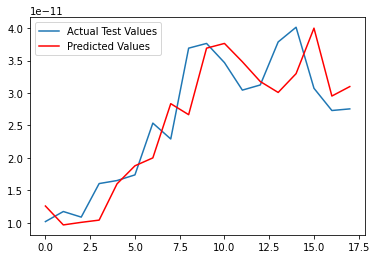

In [63]:
# plot forecasts against actual outcomes
pyplot.plot(test, label="Actual Test Values")
pyplot.plot(predictions, color='red', label="Predicted Values")
pyplot.legend(loc="upper left")

pyplot.show()

### Burn Rate Analytics

In [ ]:
API_KEY = 'TJTSNQKWSDWDSUMMZQ9GTVGHRTGY184U3K'

Normal transactions

In [5]:
'https://api.etherscan.io/api?module=account&action=txlist&address=0xddbd2b932c763ba5b1b7ae3b362eac3e8d40121a&startblock=0&endblock=99999999&sort=asc&apikey=YourApiKeyToken'

Internal transactions

In [14]:
'https://api.etherscan.io/api?module=account&action=txlistinternal&address=0x2c1ba59d6f58433fb1eaee7d20b26ed83bda51a3&startblock=0&endblock=2702578&sort=asc&apikey=YourApiKeyToken'

'https://api.etherscan.io/api?module=account&action=txlistinternal&address=0x2c1ba59d6f58433fb1eaee7d20b26ed83bda51a3&startblock=0&endblock=2702578&sort=asc&apikey=YourApiKeyToken'

In [ ]:
rb_contract = '0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c'

In [24]:
normal_trx_url = 'https://api.etherscan.io/api?module=account&action=txlist&address=0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c&startblock=0&endblock=99999999&sort=asc&apikey=TJTSNQKWSDWDSUMMZQ9GTVGHRTGY184U3K'

In [44]:
internal_trx_url = 'https://api.etherscan.io/api?module=account&action=txlistinternal&address=0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2&startblock=0&endblock=99999999&sort=asc&apikey=TJTSNQKWSDWDSUMMZQ9GTVGHRTGY184U3K'

In [45]:
res = requests.get(internal_trx_url)
res

<Response [200]>

In [46]:
j = res.json()

# print(j)
filename ="rb_trx_data.csv"

In [96]:
df = pd.read_csv('data/rb_transfers.csv')
df

Txhash   Blockno  \
0      0xb8b23ea89a8583200f25fa71d96409d45e4746dfe83e...  11812643   
1      0x918504c32da1ee19e28fdb36ab5ea61831df81f5e906...  11812884   
2      0x918504c32da1ee19e28fdb36ab5ea61831df81f5e906...  11812884   
3      0x918504c32da1ee19e28fdb36ab5ea61831df81f5e906...  11812884   
4      0x5b7b84a4926a6091df58e8c9b5a39e54997dadfe865a...  11812923   
...                                                  ...       ...   
19995  0xbcc3308ca3e1943ffa9779d60527881f7d42c5670315...  12404151   
19996  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19997  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19998  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19999  0x9c6733b26a5328091f5d2482f546687fafc73fdc23c9...  12404172   

       UnixTimestamp             DateTime  \
0         1612745014  2021-02-08 00:43:34   
1         1612748360  2021-02-08 01:39:20   
2         1612748360  2021-02-08 01:39:20   
3         1612748360  2021-02-08 01:39:20   
4         1612748812  2021-02-08 01:46:52   
...              ...                  ...   
19995     1620616751  2021-05-10 03:19:11   
19996     1620616938  2021-05-10 03:22:18   
19997     1620616938  2021-05-10 03:22:18   
19998     1620616938  2021-05-10 03:22:18   
19999     1620617023  2021-05-10 03:23:43   

                                             From  \
0      0x0000000000000000000000000000000000000000   
1      0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb   
2      0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb   
3      0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb   
4      0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb   
...                                           ...   
19995  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19996  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19997  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19998  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19999  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   

                                               To  \
0      0x0e1ecb720ab2ed8e531a137ddf8c2eb5380e9ffb   
1      0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   
2      0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
3      0x18159f21d6a2f72dc97fc1d2ddebcecfa614142c   
4      0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   
...                                           ...   
19995  0x1651046e1175555940e7e6130f79f00cc52d0758   
19996  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   
19997  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19998  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19999  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   

                              Quantity  
0              777,000,000,000,000,000  
1                3,924,900,000,000,000  
2                3,924,900,000,000,000  
3              384,640,200,000,000,000  
4      3,728,930,337,332,520.377481537  
...                                ...  
19995     86,955,558,521,823.026077938  
19996         99,067,184,944.852766003  
19997         99,067,184,944.852766003  
19998      9,708,584,124,595.571068217  
19999         88,417,707,410.772441204  

[20000 rows x 7 columns]

In [72]:
df.tail(10)

blockNumber   timeStamp  \
9990     5426113  1523519514   
9991     5426116  1523519561   
9992     5426116  1523519561   
9993     5426127  1523519666   
9994     5426138  1523519869   
9995     5426159  1523520184   
9996     5426159  1523520184   
9997     5426179  1523520524   
9998     5426244  1523521319   
9999     5426247  1523521356   

                                                   hash  \
9990  0x3ecf2ecbcddde3aed90c0bb761a29177f361c8254514...   
9991  0x698aefd047d2a7428e5b4e59e19ae6449b34ea6a5a6a...   
9992  0x6f0b385b5c0ddfb6d98bdb653e0fb92c45a3b55739db...   
9993  0x120303e59166d6ca6577c6cb98c53457b39f00fea0b3...   
9994  0xba476174cb46bf83db63259070ef69141861d0d0bdf0...   
9995  0xcb30b0e92189c77d818a5d267927237121e726719217...   
9996  0xcb30b0e92189c77d818a5d267927237121e726719217...   
9997  0x20759cde3baf62cb0284a8b0b20f92250a84e7d6efb3...   
9998  0x25d317096411cda560df0a0990767344b462256aa7a1...   
9999  0xe6448ca8582ba26535d78953bbb972e36f60effbe848...   

                                            from  \
9990  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9991  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9992  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9993  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9994  0x4b9e199b618f1908d1d50882b80816003d86a782   
9995  0x793ebbe21607e4f04788f89c7a9b97320773ec59   
9996  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9997  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9998  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9999  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                              to                 value  \
9990  0xa3cea11f1590c0b2b07faea39a626be6407d34ec    234192037470725995   
9991  0x4b9e199b618f1908d1d50882b80816003d86a782   1091327173672384176   
9992  0x793ebbe21607e4f04788f89c7a9b97320773ec59   1168343323631421476   
9993  0x793ebbe21607e4f04788f89c7a9b97320773ec59   9257497763157102977   
9994  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   1720000000000000000   
9995  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2    244829843935347443   
9996  0x793ebbe21607e4f04788f89c7a9b97320773ec59      4800585175202891   
9997  0xa3cea11f1590c0b2b07faea39a626be6407d34ec    927698861527957132   
9998  0xa3cea11f1590c0b2b07faea39a626be6407d34ec  23173978664987314675   
9999  0xa3cea11f1590c0b2b07faea39a626be6407d34ec    929281665272744168   

     contractAddress input  type     gas gasUsed traceId isError errCode  
9990                        call    2300       0   0_3_0       0          
9991                        call    2300       0   0_3_0       0          
9992                        call    2300       0     4_0       0          
9993                        call    2300       0     4_0       0          
9994                        call  384837       0     0_0       0          
9995                        call  512062       0       1       0          
9996                        call    2300       0     6_0       0          
9997                        call    2300       0   0_3_0       0          
9998                        call    2300       0   0_3_0       0          
9999                        call    2300       0   0_3_0       0

In [73]:
df['hash'].to_csv('weth_hash.csv')

In [80]:
search ='0xcb30b0e92189c77d818a5d267927237121e726719217'

cond1 = df['hash'].str.contains(search)

search_df = df[cond1]
search_df

blockNumber   timeStamp  \
9995     5426159  1523520184   
9996     5426159  1523520184   

                                                   hash  \
9995  0xcb30b0e92189c77d818a5d267927237121e726719217...   
9996  0xcb30b0e92189c77d818a5d267927237121e726719217...   

                                            from  \
9995  0x793ebbe21607e4f04788f89c7a9b97320773ec59   
9996  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                              to         value  \
9995  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  2.448298e+17   
9996  0x793ebbe21607e4f04788f89c7a9b97320773ec59  4.800585e+15   

     contractAddress input  type     gas gasUsed traceId isError errCode  \
9995                        call  512062       0       1       0           
9996                        call    2300       0     6_0       0           

      converted_value  
9995         0.244830  
9996         0.004801

In [97]:
divisor = 1000000000000000000

In [98]:
df['value'] = df['value'].astype(float)

KeyError: 'value'

In [78]:
value_list = list(df['value'].unique())
value_list.sort()
value_list

[1.0,
 3.0,
 10.0,
 14.0,
 20.0,
 40.0,
 47.0,
 50.0,
 60.0,
 74.0,
 93.0,
 99.0,
 156.0,
 200.0,
 255.0,
 9147.0,
 79325.0,
 5620000.0,
 11500000000.0,
 99999999978.0,
 100000000000.0,
 333582248000.0,
 830000000000.0,
 1000000000000.0,
 1110964400725.0,
 1500000000000.0,
 2000000000000.0,
 2714100000000.0,
 4300000000000.0,
 4522870080000.0,
 8201400000000.0,
 9100000000000.0,
 10000000000000.0,
 11905158158127.0,
 16580759730670.0,
 22300000000000.0,
 24200000000000.0,
 24700000000000.0,
 27375000000000.0,
 29900000000000.0,
 30354672210500.0,
 38277704925311.0,
 38834951456311.0,
 39195480000000.0,
 53191489361702.0,
 53838652031247.0,
 53930000000000.0,
 57400000000000.0,
 63092628480000.0,
 70000000000000.0,
 74374900000000.0,
 75200000000000.0,
 90000000000000.0,
 95000000000000.0,
 100000000000000.0,
 100900000000000.0,
 104000000000000.0,
 132912510675581.0,
 137100000000000.0,
 138500000000000.0,
 146200000000000.0,
 149100000000000.0,
 150000000000000.0,
 154100000000000.0,


In [79]:
df['converted_value'] = df['value']/divisor
df.tail(5)

blockNumber   timeStamp  \
9995     5426159  1523520184   
9996     5426159  1523520184   
9997     5426179  1523520524   
9998     5426244  1523521319   
9999     5426247  1523521356   

                                                   hash  \
9995  0xcb30b0e92189c77d818a5d267927237121e726719217...   
9996  0xcb30b0e92189c77d818a5d267927237121e726719217...   
9997  0x20759cde3baf62cb0284a8b0b20f92250a84e7d6efb3...   
9998  0x25d317096411cda560df0a0990767344b462256aa7a1...   
9999  0xe6448ca8582ba26535d78953bbb972e36f60effbe848...   

                                            from  \
9995  0x793ebbe21607e4f04788f89c7a9b97320773ec59   
9996  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9997  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9998  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
9999  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                              to         value  \
9995  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2  2.448298e+17   
9996  0x793ebbe21607e4f04788f89c7a9b97320773ec59  4.800585e+15   
9997  0xa3cea11f1590c0b2b07faea39a626be6407d34ec  9.276989e+17   
9998  0xa3cea11f1590c0b2b07faea39a626be6407d34ec  2.317398e+19   
9999  0xa3cea11f1590c0b2b07faea39a626be6407d34ec  9.292817e+17   

     contractAddress input  type     gas gasUsed traceId isError errCode  \
9995                        call  512062       0       1       0           
9996                        call    2300       0     6_0       0           
9997                        call    2300       0   0_3_0       0           
9998                        call    2300       0   0_3_0       0           
9999                        call    2300       0   0_3_0       0           

      converted_value  
9995         0.244830  
9996         0.004801  
9997         0.927699  
9998        23.173979  
9999         0.929282

### Transfers file analysis

In [99]:
transfers_raw = pd.read_csv('data/rb_transfers.csv')
transfers_raw.tail(5)

Txhash   Blockno  \
19995  0xbcc3308ca3e1943ffa9779d60527881f7d42c5670315...  12404151   
19996  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19997  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19998  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19999  0x9c6733b26a5328091f5d2482f546687fafc73fdc23c9...  12404172   

       UnixTimestamp             DateTime  \
19995     1620616751  2021-05-10 03:19:11   
19996     1620616938  2021-05-10 03:22:18   
19997     1620616938  2021-05-10 03:22:18   
19998     1620616938  2021-05-10 03:22:18   
19999     1620617023  2021-05-10 03:23:43   

                                             From  \
19995  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19996  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19997  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19998  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19999  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   

                                               To  \
19995  0x1651046e1175555940e7e6130f79f00cc52d0758   
19996  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   
19997  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19998  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19999  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c   

                           Quantity  
19995  86,955,558,521,823.026077938  
19996      99,067,184,944.852766003  
19997      99,067,184,944.852766003  
19998   9,708,584,124,595.571068217  
19999      88,417,707,410.772441204

In [100]:
transfers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Txhash         20000 non-null  object
 1   Blockno        20000 non-null  int64 
 2   UnixTimestamp  20000 non-null  int64 
 3   DateTime       20000 non-null  object
 4   From           20000 non-null  object
 5   To             20000 non-null  object
 6   Quantity       20000 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


In [101]:
trx_df = transfers_raw.copy()

In [102]:
trx_df['date'] = pd.to_datetime(trx_df['DateTime']).dt.date
trx_df['year'] = pd.DatetimeIndex(trx_df['date']).year
trx_df['month'] = pd.DatetimeIndex(trx_df['date']).month
trx_df['day'] = pd.DatetimeIndex(trx_df['date']).day
trx_df['hour'] = pd.DatetimeIndex(trx_df['date']).hour.astype(str)

In [103]:
trx_df['Quantity'] = trx_df['Quantity'].replace(',','', regex=True)
trx_df['Quantity'] = trx_df['Quantity'].astype(float)
trx_df['QTY_burned_cum'] = trx_df['QTY_burned'].cumsum()

In [142]:
trx_df['QTY_burned'] = trx_df['Quantity'] * .01
trx_df['QTY_burned_cum'] = trx_df['QTY_burned'].cumsum()
trx_df.tail(5)

Txhash   Blockno  \
19995  0xbcc3308ca3e1943ffa9779d60527881f7d42c5670315...  12404151   
19996  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19997  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19998  0x15faaff35e473616435641580e0de17ac1c25ffc0251...  12404166   
19999  0x9c6733b26a5328091f5d2482f546687fafc73fdc23c9...  12404172   

       UnixTimestamp             DateTime  \
19995     1620616751  2021-05-10 03:19:11   
19996     1620616938  2021-05-10 03:22:18   
19997     1620616938  2021-05-10 03:22:18   
19998     1620616938  2021-05-10 03:22:18   
19999     1620617023  2021-05-10 03:23:43   

                                             From  \
19995  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   
19996  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19997  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19998  0xced2c9f1a933417f3a6124d3717bbf0cdc243bcf   
19999  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91   

                                               To      Quantity        date  \
19995  0x1651046e1175555940e7e6130f79f00cc52d0758  8.695556e+13  2021-05-10   
19996  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c  9.906718e+10  2021-05-10   
19997  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91  9.906718e+10  2021-05-10   
19998  0x9ddd23c1ec9c69bc833008d4d2f86f6aa491bc91  9.708584e+12  2021-05-10   
19999  0x3ea50b7ef6a7eaf7e966e2cb72b519c16557497c  8.841771e+10  2021-05-10   

       year  month  day hour    QTY_burned  QTY_burned_cum  
19995  2021      5   10    0  8.695556e+11    5.406232e+16  
19996  2021      5   10    0  9.906718e+08    5.406232e+16  
19997  2021      5   10    0  9.906718e+08    5.406232e+16  
19998  2021      5   10    0  9.708584e+10    5.406242e+16  
19999  2021      5   10    0  8.841771e+08    5.406242e+16

In [143]:
burn_df = trx_df[['date', 'QTY_burned']].groupby('date').sum().reset_index()
burn_minus_bump = burn_df[10:]

In [144]:
close_fig = go.Figure()
'''
close_fig.add_trace(go.Scatter(x=burn_minus_bump['date'], y=burn_minus_bump['QTY_burned'],
                    mode='lines',line_shape='spline',
                    name='Total Rocket Bunny Burned by Day'))


'''
close_fig = px.area(burn_minus_bump, x="date", y="QTY_burned", line_shape='spline')

close_fig.update_layout(
    title="Total Rocket Bunny Burned by Day",
    xaxis_title="Date",
    yaxis_title="Rocket Bunny Burned",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)
close_fig.show()

In [151]:
burned_cum_df = trx_df[['date', 'QTY_burned_cum']]

burned_cum_fig = go.Figure()
'''
close_fig.add_trace(go.Scatter(x=burn_minus_bump['date'], y=burn_minus_bump['QTY_burned'],
                    mode='lines',line_shape='spline',
                    name='Total Rocket Bunny Burned by Day'))


'''
burned_cum_fig = px.area(burned_cum_df, x="date", y="QTY_burned_cum", line_shape='spline')

burned_cum_fig.update_layout(
    title="Cummulative Rocket Bunny Burned by Day",
    xaxis_title="Date",
    yaxis_title="Rocket Bunny Burned",
    legend_title="Legend Title",
    font=dict(
        family="Helvetica",
        size=13,
        color="Black"
    )
)

burned_cum_fig.show()


# DASH DASHBOARD

In [27]:
app.layout = html.Div(
    children=[
        html.H1(children="Rocket Bunny Analytics",),
        html.P(
            children="Analyze the behavior of Rocket Bunny"
            " spanning the past thirty (30) days",
        ),
        dcc.Graph(
            figure=sma_fig
        ),
        dcc.Graph(
            figure=close_fig
        ),
        dcc.Graph(
            figure=gain_loss_fig
        ),
        dcc.Graph(
            figure=ema_fig
        )
    ]
)

In [28]:
sma_fig.write_html("visuals/sma.html")
sma_fig.write_html("visuals/close_fig.html")
sma_fig.write_html("visuals/gain_loss_fig.html")
sma_fig.write_html("visuals/ema_fig.html")

In [29]:
!jupyter nbconvert --to script rb_visuals.ipynb

[NbConvertApp] Converting notebook rb_visuals.ipynb to script
[NbConvertApp] Writing 8175 bytes to rb_visuals.py


# END OF PROGRAM

"HIS POWER LEVEL IS OVER 9000?!?!?!"

- Vegeta